# Bayesian Regression Model 2018/19 using priors from optimized random forest model

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

data = pd.read_csv("../data/shifts_data_final_2018_19.csv")
data.drop(data.columns[0], axis = 1, inplace = True)
data.head()

,point_diff_per_100,home_team,away_team,0,1,2,3,4,5,6,...,519,520,521,522,523,524,525,526,527,528
0,-36.458333,Celtics,Nuggets,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,Celtics,Nuggets,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
priors_df_vets = pd.read_csv("../data/final_priors_vets_2018_19.csv")
priors_df_vets.drop(priors_df_vets.columns[0], axis = 1, inplace = True)
priors_df_vets.drop(['index_y', 'player_id_y', 'player_name_x', 'player_id_y', 'index_y', 'player_name_y'], axis = 1, inplace = True)
# need to rename the index column to idx
priors_df_vets.columns = ['team', 'mu', 'sd', 'name' ,'coefs', 'idx', 'player_id', 'finalpriors', 'finalse']

priors_df_rookies = pd.read_csv("../data/final_priors_rookies_2018_19.csv")
priors_df_rookies.drop(priors_df_rookies.columns[0], axis = 1, inplace = True)
priors_df_rookies.drop(['player_name'], axis = 1, inplace = True)
# need to rename the index column to idx
priors_df_rookies.columns = ['mu', 'sd', 'name', 'type' ,'finalpriors', 'finalse', 'player_id', 'idx']

priors_df_vets.sort_values(by = ['idx'], inplace = True)
priors_df_rookies.sort_values(by = ['idx'], inplace = True)

In [3]:
n_players = np.shape(data)[1] - 3
prior_means = np.zeros(n_players)
prior_sigmas = np.full(n_players, 4)

for i in range(len(prior_means)):
    if i in np.array(priors_df_vets['idx']):
        prior_means[i] = priors_df_vets.loc[priors_df_vets['idx'] == i]['finalpriors'].iloc[0]
        prior_sigmas[i] = priors_df_vets.loc[priors_df_vets['idx'] == i]['finalse'].iloc[0]
    elif i in np.array(priors_df_rookies['idx']):
        prior_means[i] = priors_df_rookies.loc[priors_df_rookies['idx'] == i]['finalpriors'].iloc[0]
        prior_sigmas[i] = priors_df_rookies.loc[priors_df_rookies['idx'] == i]['finalse'].iloc[0]
        


In [4]:
home_teams = data['home_team']
away_teams = data['away_team']
# now drop these columns from the main training dataframe
data.drop(['home_team', 'away_team'], axis = 1, inplace = True)
data.head()

,point_diff_per_100,0,1,2,3,4,5,6,7,8,...,519,520,521,522,523,524,525,526,527,528
0,-36.458333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# need to rename columns now since numbers confuse pymc3
new_cols = []
for i in range(np.shape(data)[1]):
    if i == 0:
        new_cols.append("point_diff")
    else:
        new_cols.append("p" + str(i-1))

# x_df = data.iloc[:20000,]
x_df = data
x_df.columns = new_cols
x_df

,point_diff,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p519,p520,p521,p522,p523,p524,p525,p526,p527,p528
0,-36.458333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33885,-52.083333,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33886,38.868159,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33887,60.562016,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33888,-72.337963,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
x = np.array(x_df.iloc[:,1:])
y = np.array(x_df.iloc[:,0])

x_shape = np.shape(x)[1]
    
with pm.Model() as model:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sigmas # defined above
#     x_prior_means = np.zeros(x_shape) # just testing with mean zero to compare to ridge
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape) # original method - no list comprehension

    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y) # original method - no list comprehension
    
    trace = pm.sample(1000, tune = 1000, cores = 1)
    
    

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1856 seconds.


# Save the trace

In [27]:
with model:
    path = pm.save_trace(trace, directory = "trace_2018_19")

In [7]:
with model:
    results_df = az.summary(trace)

In [9]:
player_index_map = pd.read_csv("../data/player_index_map.csv")
player_index_map.head()

,Unnamed: 0,player_id,index,player_name
0,0,202694.0,0,Marcus Morris
1,1,1628369.0,1,Jayson Tatum
2,2,1627759.0,2,Jaylen Brown
3,3,1626179.0,3,Terry Rozier
4,4,201577.0,4,Robin Lopez


In [24]:
player_index_map.loc[player_index_map['index'] == 1]
# player_index_map.loc[player_index_map['player_name'] == "LeBron James"]

,Unnamed: 0,player_id,index,player_name
1,1,1628369.0,1,Jayson Tatum


In [10]:
print((results_df.loc[results_df['mean'] > 4]).sort_values(by=['mean']))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[256]   4.033  2.426  -0.420    8.631      0.038    0.035    4075.0   
x[71]    4.052  2.467  -0.796    8.516      0.037    0.033    4379.0   
x[319]   4.229  2.796  -0.580    9.808      0.044    0.041    4011.0   
x[20]    4.231  2.605  -0.801    8.936      0.047    0.038    3107.0   
x[95]    4.231  2.372  -0.101    8.688      0.038    0.033    3890.0   
x[291]   4.241  2.504  -0.163    8.962      0.039    0.034    4145.0   
x[388]   4.318  2.471  -0.153    9.171      0.040    0.036    3848.0   
x[244]   4.336  2.619  -0.240    9.437      0.036    0.037    5202.0   
x[190]   4.450  2.570  -0.147    9.490      0.043    0.037    3563.0   
x[225]   4.506  2.489  -0.110    9.432      0.034    0.034    5201.0   
x[67]    4.515  2.501  -0.372    8.999      0.040    0.034    3974.0   
x[489]   4.527  3.602  -2.583   10.922      0.053    0.057    4612.0   
x[275]   4.567  2.628  -0.260    9.409      0.037    0.034    50

In [25]:
with model:
    tmp = trace.get_values("x")

# np.shape(tmp)
# np.mean(tmp, axis = 0)
tmp_df = pd.DataFrame(tmp)
tmp_df.to_csv(r'../data/bayesian_posterior_samples_2018_19.csv')

In [26]:
results_df.to_csv(r'../data/bayesian_results_df_2018_19.csv')

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


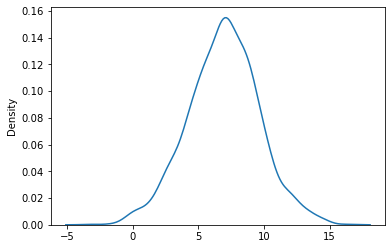

In [28]:
import seaborn as sns

with model:
#     az.plot_trace(trace3)
#     print(np.shape(trace3['x']))
#     print(max(trace3['x'][:,317]))
    sns.distplot(trace['x'][:,317], hist = False)